<a href="https://colab.research.google.com/github/alexjercan/normals-estimation/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib==3.3.3 albumentations==0.5.2

     |████████████████████████████████| 11.6MB 313kB/s 
     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 952kB 8.7MB/s 
     |████████████████████████████████| 37.6MB 93kB/s 
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:
!git clone https://github.com/alexjercan/normals-estimation.git
%cd normals-estimation

import torch
from IPython.display import clear_output

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 CPU


In [2]:
# Download bdataset
torch.hub.download_url_to_file('https://github.com/alexjercan/depth-estimation/releases/download/v1.0/bdataset_stereo.zip', 'tmp.zip')
!unzip -q tmp.zip -d ../ && rm tmp.zip

In [13]:
!git pull
!python dataset.py
!python model.py

remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 19 (delta 15), reused 19 (delta 15), pack-reused 0
Unpacking objects: 100% (19/19), done.
From https://github.com/alexjercan/normals-estimation
   8bc9de7..27d89eb  master     -> origin/master
Updating 8bc9de7..27d89eb
Fast-forward
 dataset.py |  10 +-
 detect.py  |   9 +-
 general.py |   1 +
 metrics.py |   8 +-
 model.py   | 383 +++++++++++++++++++------------------------------------------
 test.py    |   1 +
 test.yaml  |   2 +-
 train.py   |  13 ++-
 train.yaml |   8 +-
 util.py    |  26 +----
 10 files changed, 153 insertions(+), 308 deletions(-)
dataset ok
model ok


In [6]:
import os
import re
import torch
import torch.optim
import albumentations as A
import my_albumentations as M

from datetime import datetime as dt
from albumentations.pytorch.transforms import ToTensorV2
from config import DEVICE
from model import Model, LossFunction
from general import init_weights, load_checkpoint, save_checkpoint
from dataset import create_dataloader
from metrics import MetricFunction, print_single_error
from detect import generatePredictions
from train import train_one_epoch
from test import run_test
from util import save_predictions, plot_predictions
from dataset import LoadImages

IMAGE_SIZE = 256
DATASET_ROOT = "../bdataset_stereo"
TRAIN_JSON_PATH = "train.json"
TEST_JSON_PATH = "test.json"
IMAGES = [{"imageL": "data/left.png", "imageR": "data/right.png", "output": "data/output.exr"}]
BATCH_SIZE = 8
WORKERS = 8

LEARNING_RATE = 0.1
EPS = 0.00000001
MOMENTUM = 0.9
DAMPENING = 0.1
WEIGHT_DECAY = 0.0001

BETAS = [.9, .999]
MILESTONES = [25, 50, 75]
GAMMA = .5

NUM_EPOCHS = 100
OUT_PATH = "./runs"
LOAD_TRAIN_MODEL = False
LOAD_TEST_MODEL = False
CHECKPOINT_TRAIN_FILE = "normal.pth"
CHECKPOINT_TEST_FILE = "normal.pth"

torch.backends.cudnn.benchmark = True

In [7]:
train_transform = A.Compose(
    [
        M.MyRandomResizedCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            M.MyOpticalDistortion(p=0.3),
            M.MyGridDistortion(p=0.1),
            M.MyIAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_normal': 'normal',
        'right_normal': 'normal',
    }
)

test_transform = A.Compose(
    [
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_normal': 'normal',
        'right_normal': 'normal',
    }
)

detect_transform = A.Compose(
    [
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        A.Normalize(),
        ToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
    }
)

_, train_dataloader = create_dataloader(DATASET_ROOT, TRAIN_JSON_PATH, 
                                        batch_size=BATCH_SIZE, transform=train_transform, 
                                        workers=WORKERS, pin_memory=True, shuffle=True)

_, test_dataloader = create_dataloader(DATASET_ROOT, TEST_JSON_PATH,
                                       batch_size=BATCH_SIZE, transform=test_transform,
                                       workers=WORKERS, pin_memory=True, shuffle=False)


In [8]:
model = Model()
model.apply(init_weights)
# solver = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
#                           lr=LEARNING_RATE, betas=BETAS, 
#                           eps=EPS, weight_decay=WEIGHT_DECAY)
solver = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
                         lr=LEARNING_RATE, momentum=MOMENTUM,
                         dampening=DAMPENING, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(solver, milestones=MILESTONES, gamma=GAMMA)
model = model.to(DEVICE)
loss_fn = LossFunction()

In [9]:
epoch_idx = 0
if LOAD_TRAIN_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_FILE, DEVICE)

model.train()
for epoch_idx in range(epoch_idx, NUM_EPOCHS):
    metric_fn = MetricFunction(BATCH_SIZE)
    train_one_epoch(model, train_dataloader, loss_fn, metric_fn, solver, epoch_idx)
    print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())
    lr_scheduler.step()


100%|██████████| 27/27 [13:06<00:00, 29.12s/it, epoch=0, loss=(total:1.3181 l1:0.2664420008659363 1-cos:1.0516434907913208)]

eval_avg_error
Epoch: 0, loss=(total:1.3181 l1:0.2664420008659363 1-cos:1.0516434907913208)
======NORMALS=======
MSE=2.6324	RMSE=1.6216	MAE=1.5686	MME=1.5708
TANGLE11.25=0.0031	TANGLE22.5=0.0115	TANGLE30.0=0.0239



In [10]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_FILE, DEVICE)

model.eval()
metric_fn = MetricFunction(BATCH_SIZE)
run_test(model, test_dataloader, loss_fn, metric_fn)
print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())

100%|██████████| 14/14 [02:11<00:00,  9.37s/it]

eval_avg_error
Epoch: 0, loss=(total:1.5284 l1:0.301997572183609 1-cos:1.2264204025268555)
======NORMALS=======
MSE=2.6624	RMSE=1.6282	MAE=1.5840	MME=1.5708
TANGLE11.25=0.0012	TANGLE22.5=0.0059	TANGLE30.0=0.0111



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


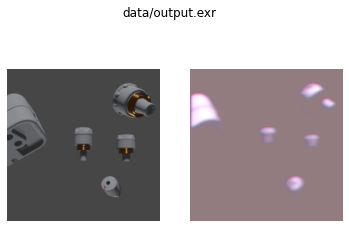

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


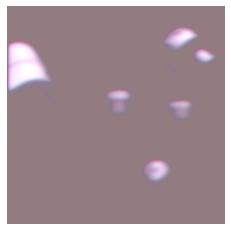

In [11]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_FILE, DEVICE)

model.eval()
images = LoadImages(IMAGES, transform=detect_transform)
for img, predictions, path in generatePredictions(model, images):
    plot_predictions([img], predictions, [path])
    save_predictions(predictions, [path])

In [12]:
output_dir = os.path.join(OUT_PATH, re.sub("[^0-9a-zA-Z]+", "-", dt.now().isoformat()))

save_checkpoint(epoch_idx, model, output_dir)